In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from knee_stress_predict.config import raw_data_dir, processed_data_dir

# FEATURE EVALUATION

This notebook evaluate initial features and based on that evaluation it cleans the data for linear regression model

Load data produced by patients_data_loading.ipynb notebook

In [4]:
data_set_name = "set_2"
file_path = Path.joinpath(processed_data_dir, data_set_name,  "out.csv")
result = pd.read_csv(file_path)
result

,Unnamed: 0,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,...,Tibia_M_Car_bounds_z,Tibia_L_Car_bounds_z,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,Max_tib_lat_contact_pressure,Max_tib_med_contact_pressure
0,0,9905863M00,923,4011,3009,4745,19095,2840,2840,28699.200017,...,51.821435,38.669460,17.745715,2.039169,6.118655,12.363764,1.604390,4.737838,20.304403,21.124319
1,1,9905863M12,884,4110,2790,4585,19025,2840,2840,28197.827325,...,49.585413,39.525092,17.898652,1.921611,5.881292,11.342142,1.238408,4.577601,16.648224,24.434072
2,2,9908796M00,641,2861,2268,4120,20295,2840,2840,15222.439598,...,42.175751,34.364839,17.383859,1.526717,5.834900,11.786139,1.642169,4.761267,24.156282,32.353172
3,3,9908796M12,625,3022,2171,4715,19385,2840,2840,14931.893097,...,42.911019,33.854403,15.747611,1.651787,5.670845,9.728744,1.010164,4.052701,26.788031,41.688950
4,4,9912946M00,788,4137,2689,5575,21035,2840,2840,22692.085291,...,45.878323,53.532299,13.779237,1.205597,4.272830,20.666032,2.178122,6.670601,24.228903,16.497473
5,5,9912946M12,791,4298,2533,5685,20945,2840,2840,22884.798440,...,44.778685,54.848365,14.812026,1.317364,4.527756,20.625497,2.362209,6.585939,20.500221,16.258379
6,6,9954040M00,803,3417,2512,5015,20230,2840,2350,23008.003160,...,41.209505,50.400081,14.405036,1.791824,5.394328,19.520492,1.581902,6.630810,21.599136,23.253128
7,7,9954040M12,812,3233,2740,4885,20345,2840,2360,22994.325369,...,41.165844,50.319550,14.258336,1.599123,5.315656,20.528995,1.629729,6.670640,22.697514,22.974691
8,8,9958234M00,759,3696,2606,5235,21865,2840,2840,20235.363396,...,41.892000,50.649900,16.565555,1.481842,5.632349,19.478773,2.755818,7.313583,47.319096,18.733936
9,9,9958234M12,752,3674,2669,5225,22195,2840,2840,20204.268573,...,42.959333,49.449277,16.466665,1.677136,5.663880,20.177378,2.723724,7.444552,33.180820,18.182465


In [5]:
result = result.drop('Unnamed: 0', axis=1)

## Correlations between variables


Text(0.5, 1.0, 'All patients Correlation Heatmap')

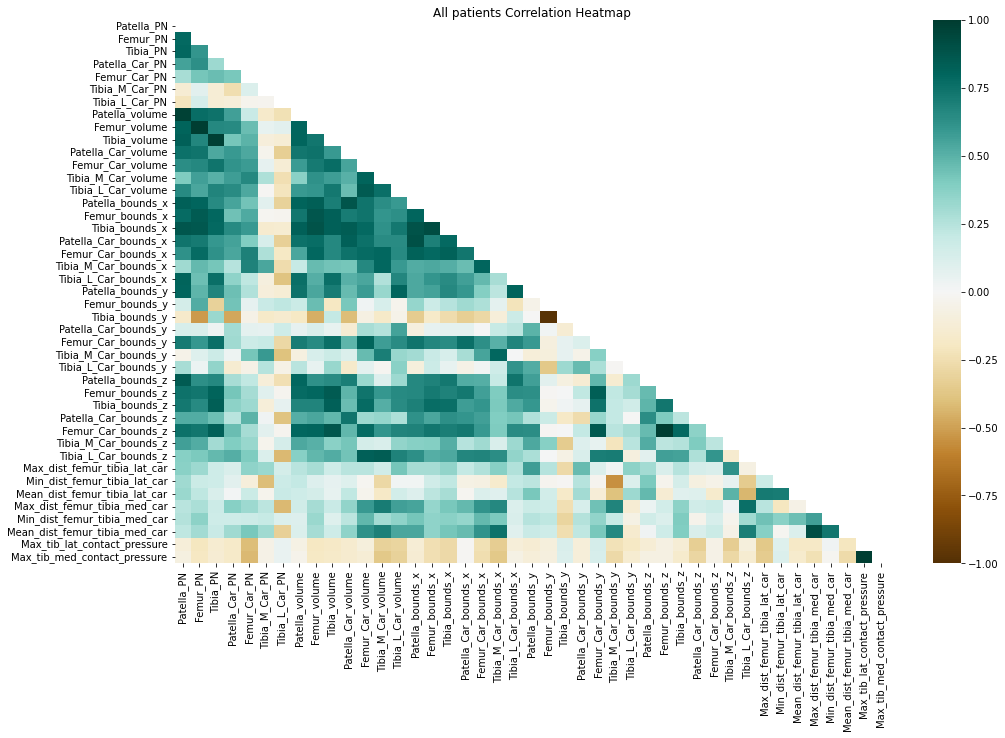

In [6]:
plt.figure(figsize=(16, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(result.corr(), dtype=np.bool))
heatmap = sns.heatmap(result.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('All patients Correlation Heatmap', fontdict={'fontsize':12}, pad=0)

Max_tib_med_contact_pressure and Max_tib_lat_contact_pressure are variables that we try to predict. They have a strong positive correlation with each other. Besides that, they are slightly correlated with Femur_Car_PN.
However, this data does not show any promising features that we can use for linear regression. Let's examine the distribution and see if it will give us some insight.
Additionally, on that correlation heat map, we can see that many features strongly correlate with each other. So we can minimize the number of features by combing correlated features or choosing one.

## Check distribution of maximal contact pressure

(array([18.,  8.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  16.25837898,   26.81556326,   37.37274754,   47.92993181,
          58.48711609,   69.04430037,   79.60148464,   90.15866892,
         100.7158532 ,  111.27303747,  121.83022175,  132.38740602,
         142.9445903 ,  153.50177458,  164.05895885,  174.61614313,
         185.17332741,  195.73051168,  206.28769596,  216.84488024,
         227.40206451,  237.95924879,  248.51643307,  259.07361734,
         269.63080162,  28

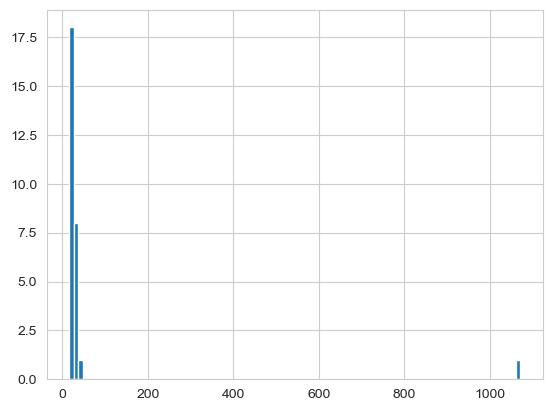

In [351]:
plt.hist(result['Max_tib_med_contact_pressure'], bins = 100)

(array([5., 6., 6., 5., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 14.55892467,  17.77144853,  20.98397238,  24.19649623,
         27.40902008,  30.62154393,  33.83406778,  37.04659163,
         40.25911549,  43.47163934,  46.68416319,  49.89668704,
         53.10921089,  56.32173474,  59.53425859,  62.74678245,
         65.9593063 ,  69.17183015,  72.384354  ,  75.59687785,
         78.8094017 ,  82.02192555,  85.23444941,  88.44697326,
         91.65949711,  94.87202096,  98.08454481, 101.29706866,
        104.50959251, 107.72211637, 110.93464022, 114.14716407,
        117.35968792, 120.57221177, 12

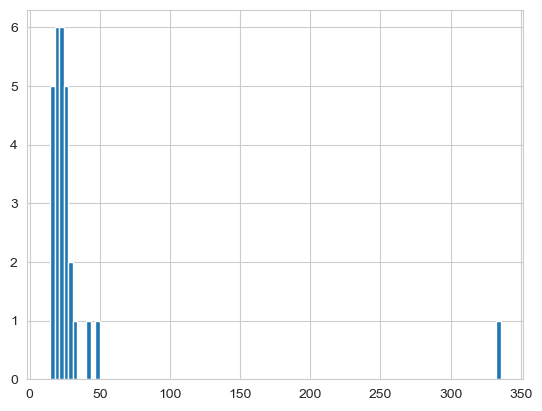

In [352]:
plt.hist(result['Max_tib_lat_contact_pressure'], bins = 100)

Contact pressure for both medial and lateral cartilages is distributed very unequally. There are outliers with unusually high contact pressure. Let’s remove outliers, knee with high maximal tibia cartilage contact pressure (>100), and see if the correlation matrix will change.

In [353]:
result_no_outliers = result[result['Max_tib_lat_contact_pressure'] < 100]
result_no_outliers = result_no_outliers[result_no_outliers['Max_tib_med_contact_pressure'] < 100]
result_no_outliers.describe()

,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,Tibia_volume,...,Tibia_M_Car_bounds_z,Tibia_L_Car_bounds_z,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,Max_tib_lat_contact_pressure,Max_tib_med_contact_pressure
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,757.370370,3587.666667,2603.814815,4735.185185,20454.814815,3128.518519,2808.333333,20384.067554,196315.267555,133624.247705,...,44.200762,42.083535,16.337213,1.808215,5.850811,15.154763,2.051157,5.692129,23.975754,25.632383
std,88.040265,409.039588,312.159357,486.989341,1386.526153,878.458894,139.594192,4099.389649,36115.868290,24106.368613,...,4.478084,7.553499,2.291186,0.680153,0.972722,4.130566,0.716737,1.229198,7.324567,6.802071
min,618.000000,2861.000000,2062.000000,3925.000000,16950.000000,2155.000000,2350.000000,14319.651370,140615.628188,92428.606648,...,35.934487,29.333132,12.502042,-0.419731,4.026413,9.200243,1.010164,3.736493,14.558925,16.258379
25%,678.500000,3256.000000,2398.500000,4367.500000,19492.500000,2840.000000,2840.000000,16564.915179,168443.423827,112739.224622,...,41.232515,35.687204,14.568597,1.504279,5.513338,11.564140,1.543849,4.581213,20.262472,21.701577
50%,776.000000,3669.000000,2575.000000,4715.000000,20400.000000,2840.000000,2840.000000,20204.268573,207103.898292,136753.285023,...,43.515813,41.816828,16.044102,1.874496,5.873500,15.426130,1.765259,5.525146,22.231998,23.203386
75%,807.500000,3872.000000,2810.500000,4950.000000,21175.000000,2840.000000,2840.000000,23001.164265,220182.540980,146487.283702,...,48.336731,49.344271,17.693008,2.199361,6.311733,19.499633,2.542966,6.670621,26.449284,31.197783
max,923.000000,4298.000000,3383.000000,5690.000000,23675.000000,5530.000000,3075.000000,28699.200017,258760.708517,189256.363446,...,51.821435,54.848365,21.446570,2.669850,8.009479,20.666032,3.345730,7.498194,47.319096,41.688950


Text(0.5, 1.0, 'No outliers Correlation Heatmap')

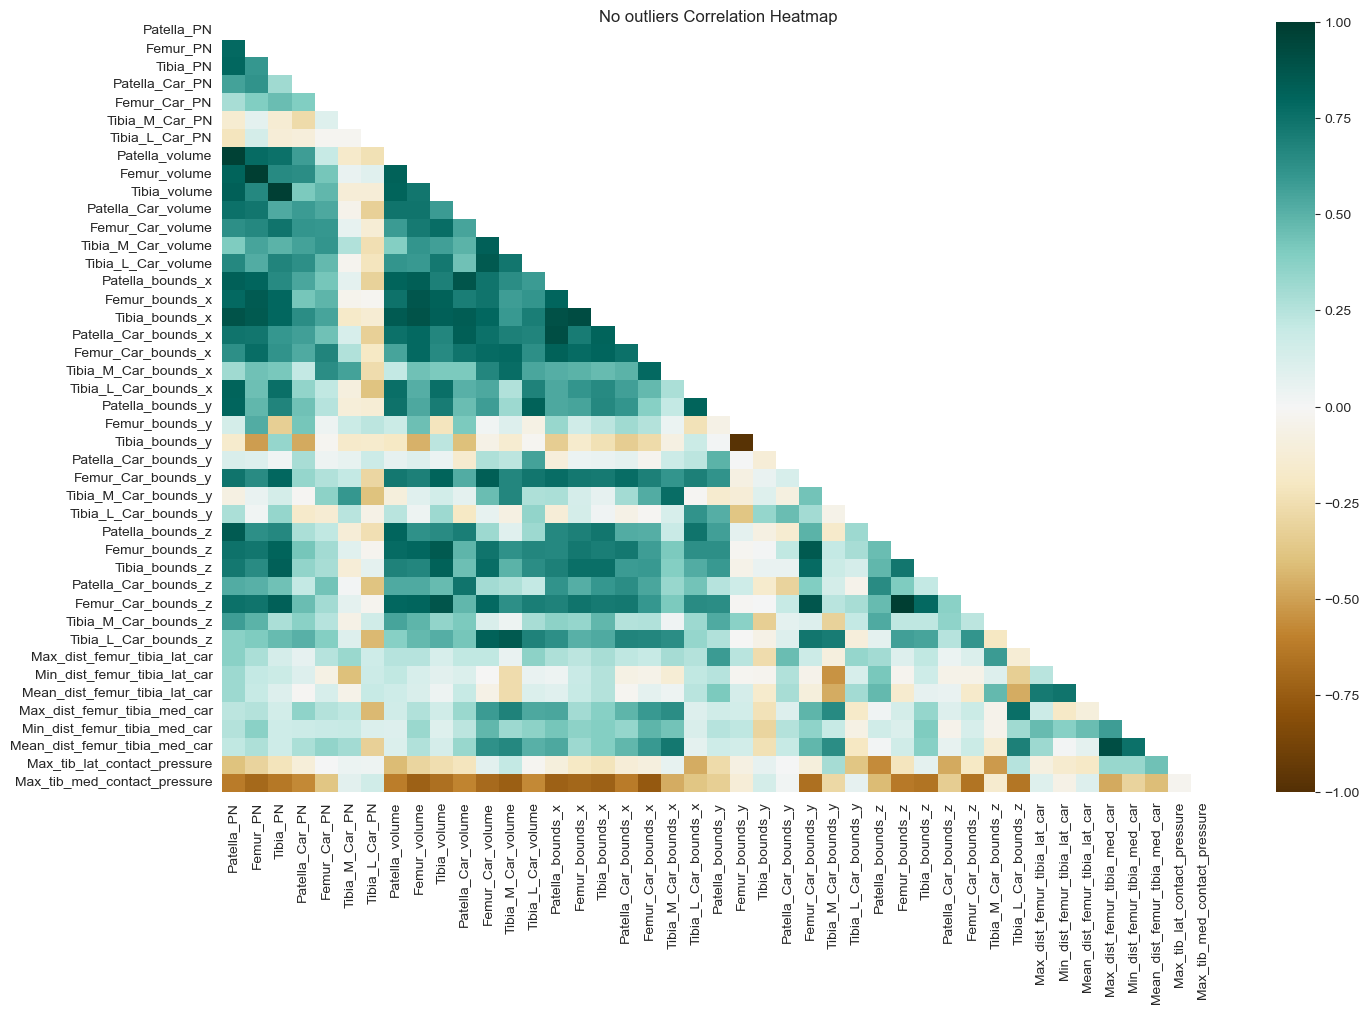

In [354]:
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(result.corr(), dtype=np.bool))
heatmap = sns.heatmap(result_no_outliers.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('No outliers Correlation Heatmap', fontdict={'fontsize':12}, pad=0)

We can see that Max_tib_med_contact_pressure has higher negative correlation numbers with other features after removing outliers. Max_tib_med_contact_pressure is less correlated with features. It can be caused by the small size of the set.

## Choose features for linear regression analysis.

In [355]:
filtered_result = result_no_outliers.copy()

### Remove patella data

We can ignore patella information for now based on Kalin's comments

In [356]:
filtered_result = filtered_result.drop(['Patella_PN', 'Patella_volume',
                                        'Patella_Car_PN', 'Patella_Car_volume',
                                        'Patella_bounds_x', 'Patella_bounds_y', 'Patella_bounds_z',
                                        'Patella_Car_bounds_x', 'Patella_Car_bounds_y', 'Patella_Car_bounds_z',], axis=1)

### Remove features based on low correlation coefficient with predicting variables

Let's choose only columns that have a correlation coefficient with tibia pressure > 0.25

In [357]:
corr_cut_off = 0.60
# Iterate over column names
for column in filtered_result:
    if pd.api.types.is_numeric_dtype(filtered_result[column]):
        corr_med = filtered_result['Max_tib_lat_contact_pressure'].corr(filtered_result[column])
        corr_lat = filtered_result['Max_tib_med_contact_pressure'].corr(filtered_result[column])
        if abs(corr_med) < corr_cut_off and abs(corr_lat) < corr_cut_off:
            print(column, corr_med, corr_lat)
            filtered_result = filtered_result.drop(column, axis=1)
filtered_result.info()

Femur_Car_PN 0.0011604461866801946 -0.37573700287246575
Tibia_M_Car_PN 0.045470139941404586 0.07960395920930272
Tibia_L_Car_PN 0.0321065913885504 0.1616988546396185
Tibia_L_Car_volume -0.020066666076251797 -0.5738280476859964
Tibia_M_Car_bounds_x 0.062394339176572326 -0.4627852263581981
Tibia_L_Car_bounds_x -0.46160061776222977 -0.38049592924982806
Femur_bounds_y -0.07523345473190766 -0.11932806862487753
Tibia_bounds_y 0.06716659155929111 0.14713819312977108
Tibia_M_Car_bounds_y 0.29529922862855174 -0.28309497055242033
Tibia_L_Car_bounds_y -0.37908888042639843 0.06324181439704664
Tibia_M_Car_bounds_z -0.521164744004891 -0.14951545754980966
Max_dist_femur_tibia_lat_car -0.08590794488583092 0.09525067092270247
Min_dist_femur_tibia_lat_car -0.1498971285442925 -0.058420453227117655
Mean_dist_femur_tibia_lat_car -0.18638229194851258 0.10446110768991938
Max_dist_femur_tibia_med_car 0.33363292543357304 -0.4727416057027525
Min_dist_femur_tibia_med_car 0.33265865379756765 -0.31088940560701905
M

### Remove features with strong correlation

Multicollinearity between features violates the independent data assumption of linear regression. We have feature columns that are dependent on each other. For example, Patella_volume strongly correlated with Patelle_PN (patella points number).

Let's use VIF ( Variance Influence Factor ) to see what data can be removed. The higher VIF value, higher is the possibility of dropping the column while making the actual Regression model.

In [358]:
def get_VIF(dataFrame , target):
    X = add_constant(dataFrame.loc[:, dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
    return seriesObject

In [359]:

for column in filtered_result.drop('Code', axis=1):
    vif= get_VIF(filtered_result.drop('Code', axis=1),column)
    for index, value in vif.iloc[1:].iteritems():
        if value > 40:
            print(f"Remove on of two featues: {column} or {index}")


Remove on of two featues: Femur_PN or Tibia_PN
Remove on of two featues: Femur_PN or Femur_volume
Remove on of two featues: Femur_PN or Tibia_volume
Remove on of two featues: Femur_PN or Tibia_bounds_x
Remove on of two featues: Femur_PN or Femur_bounds_z
Remove on of two featues: Femur_PN or Femur_Car_bounds_z
Remove on of two featues: Tibia_PN or Femur_PN
Remove on of two featues: Tibia_PN or Femur_volume
Remove on of two featues: Tibia_PN or Tibia_volume
Remove on of two featues: Tibia_PN or Tibia_bounds_x
Remove on of two featues: Tibia_PN or Femur_bounds_z
Remove on of two featues: Tibia_PN or Femur_Car_bounds_z
Remove on of two featues: Femur_volume or Femur_PN
Remove on of two featues: Femur_volume or Tibia_PN
Remove on of two featues: Femur_volume or Tibia_volume
Remove on of two featues: Femur_volume or Femur_bounds_z
Remove on of two featues: Femur_volume or Femur_Car_bounds_z
Remove on of two featues: Tibia_volume or Femur_PN
Remove on of two featues: Tibia_volume or Tibia_PN

After checking the above list let's remove Frmur_volumea since we will still have Femur_PN


In [360]:
# filtered_result = filtered_result.drop(['Tibia_volume'], axis=1)

Let's build one more coffelation heat map

Text(0.5, 1.0, 'No outliers Correlation Heatmap')

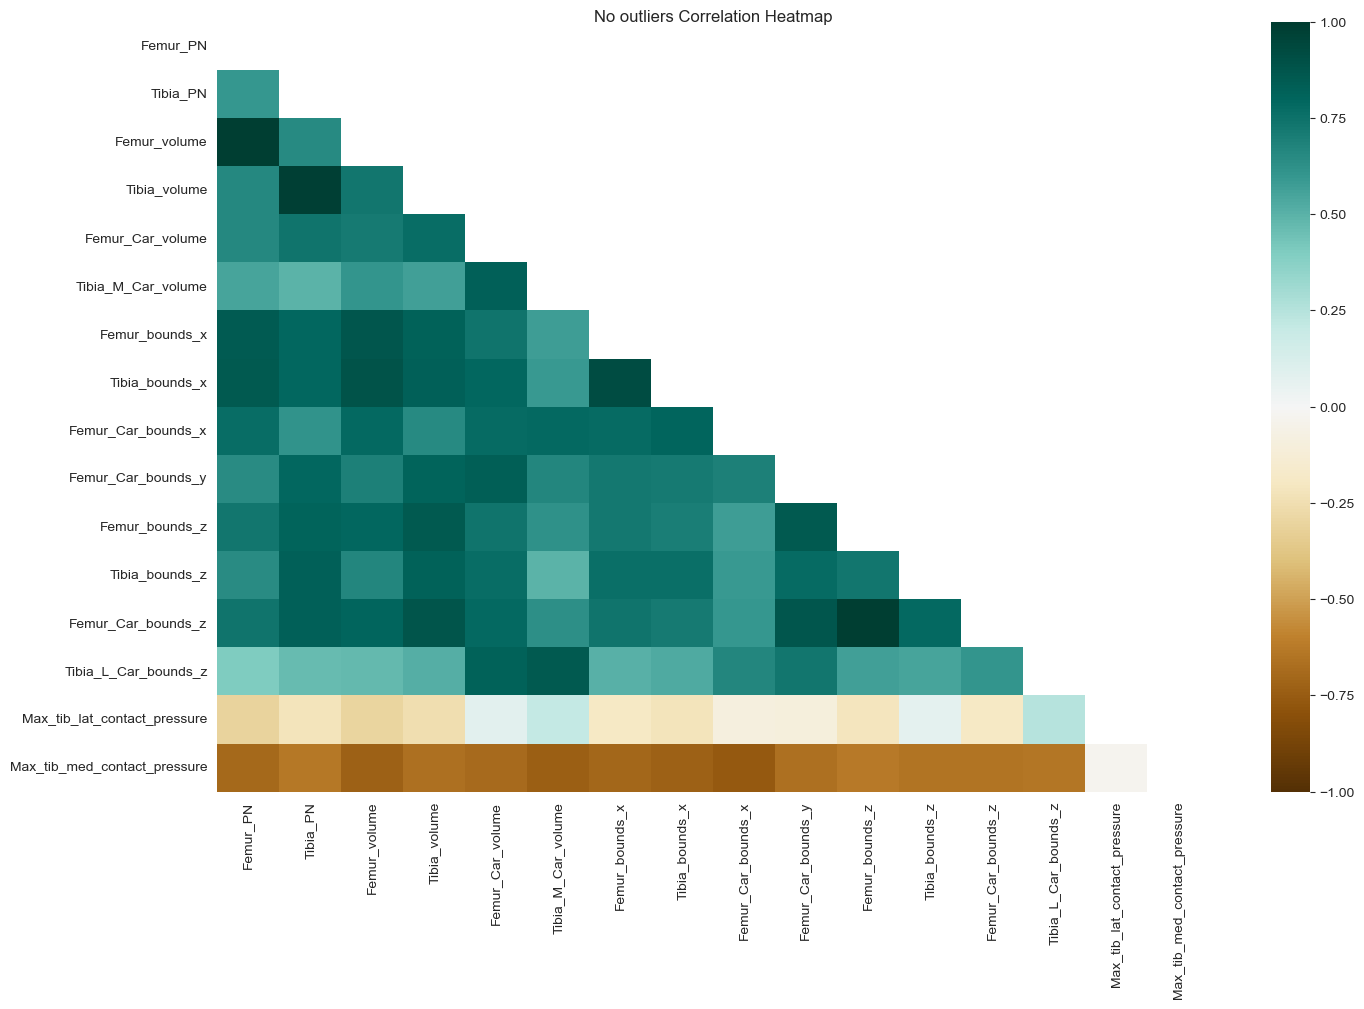

In [361]:
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(filtered_result.corr(), dtype=np.bool))
heatmap = sns.heatmap(filtered_result.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('No outliers Correlation Heatmap', fontdict={'fontsize':12}, pad=0)

In [362]:
output_path = Path.joinpath(processed_data_dir, data_set_name, "out_cleaned.csv")
result.to_csv(output_path)
output_path

WindowsPath('D:/University/Classes/CS481_Senior_Design_Project/f22-ai-cbl/data/processed/set_2/out_cleaned.csv')